-----------

# TRABAJO PRACTICO FINAL

### DIGITAL HOUSE: Data Science
### Junio 2022

<br>

## GRUPO 1
- Integrantes:
    - Gonzalo Barbot - PM: Project Manager
    - Agustin Stigliano - CDM: Code Development Manager
    - Fernando Dupont - PDM: Presentation Development Manager
    
<br>

## TEMA: Pronósticos sobre Series Temporales
<br>

-----

# NOTEBOOK MACHINE LEARNING:


### IMPORTACION DE LIBRERIAS

Activación de logging

In [1]:
import SmartSeries
import APP_REG_LOG_EST as reg
import APP_ARIMA as arima
import APP_XGBOOST as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import pickle
import time

import logging
import datetime as dt
formatter = '%(levelname)s:\n %(message)s | %(asctime)s\n'#| line %(lineno)d\n'
logging.basicConfig(filename='logfile_Machine_learning.log', level=logging.INFO, force=True, filemode='w', **{'format':formatter})
logger = logging.getLogger()

xgboost version actual: 1.5.0
Version de diseño en 14/6/2022
	xgboost version: 1.6.0


In [2]:
# MODULO DE ARRANQUE
import SmartPandas
from SmartPandas import x_en
def x():
    return x_en('log_ML')

def show_df(df):
    display (df)
    print (df.index)
    display (SmartPandas.data_info(df))


log_message  = '{}) STARTING PROGRAM'
logger.info(log_message.format(x()))
SmartSeries.apply_dark_mode()

### CARGA DEL DATASET: TIME SERIE

In [3]:
# MODULO DE CARGA DE DATOS
file_name = 'df_targets.csv'
df = SmartSeries.load_dataset(file_name, freq='D', dropnan=False, fillnan=True)
log_message = '{}) LOADING FUNCTION: load_dataset(): se carga el dataset llamado "{}"'
logger.info(log_message.format(x(), file_name))


Serie de tiempo: date

Cantidad de NaNs en: 
Grocery             0
Pharmaceutical      0
Natural_Products    0
Bakery              1
Meat                1
NaNs imputados: método "backfill"


In [4]:
# lo que hacemos todos siempre: Chequear 2 veces las cosas
df.isna().sum()

Grocery             0
Pharmaceutical      0
Natural_Products    0
Bakery              0
Meat                0
dtype: int64

### CREACION DE LAS MATRICES TARGETS

<b>SmartSeries

In [5]:
# CREAMOS LOS VECTORES TIME SERIE
labels_category = df.columns.values

vector = SmartSeries.VectorBuilder(df)
vectores = {}
for elemento in labels_category:
    vector.create(elemento)
    vector.treatment()
    vector.dummy('W')
    vectores[elemento] = vector.vector


Serie de tiempo: date



In [6]:
# interactive display
vector.targets
vectores.keys()
vectores['Pharmaceutical'];# vectores['Pharmaceutical'].index

# MODELO 1: reg_log_est

**MODELO DE REGRESION LINEAL CON TRANSFORMACIÓN LOGARÍTMICA Y ESTACIONALIDAD**



In [7]:
def check_optimized_model(results, umbral):
    return results.loc[results[umbral].astype('float64').idxmin()].to_frame().T

def get_optimized_model(modelos, scores):
    return modelos[pd.Series(scores).idxmin()]

Entrenamiento de 6 modelos seleccion por umbral, quedandose con el mejor de cada modelo.

In [8]:
log_message = '{}) ELIJE LAS VARIABLES PARA FORECAST'
logger.critical(log_message.format(x()))
#####################################################################################################
umbral = 'Natural_Products' # category to implement forecast
umbral_2 = 60 # test_size for train test split
umbral_3 = 'RMSE' # es para evitar fallas

muestra = vectores[umbral]
modelos_reg_log_est = reg.available_models()
nombre_modelos = reg.def_models()

#train test split: 60 dias = 2 meses
df_train, df_test = train_test_split(muestra, shuffle=False, test_size=umbral_2)

# iteracion para instanciar el modelo de statsmodels
for i in range(len(modelos_reg_log_est)):
    modelos_reg_log_est[i] = modelos_reg_log_est[i](muestra, vector, umbral)

# iteracion para entrenar los modelos_reg_log_est instanciados, y almancenar el score de las predicciones
scores = []
for i in range(len(modelos_reg_log_est)):
    modelos_reg_log_est[i] = modelos_reg_log_est[i].fit()
    y_pred = modelos_reg_log_est[i].predict(df_test)
    if i <= 3: y_pred = np.exp(y_pred) # los primeros 4 modelos_reg_log_est predicen sobre el logartimo del target
    scores.append(np.sqrt(mean_squared_error(df_test[vector.target], y_pred)))

#resultados = {}
results_reg_log_est = pd.DataFrame([nombre_modelos, scores]).T
log_message = '{}) ALTERATION OF VARIABLE TYPE: Cuando creo un dataset a partir de un conjunto de listas, los valores float me los convierte en series tipo "Object"'
logger.warning(log_message.format(x()))
results_reg_log_est.columns = ['Modelo', umbral_3]

log_message = '{}) implementando la funcion "check_optimized_model" tiene hardseteado la label "RMSE", definida previamente en la linea superior a esta'
# aca vamos a usar un dataset aparte, usando "nombre_modelos"
optimized_umbral_model = get_optimized_model(modelos_reg_log_est, scores)

### Dickey-Fuller test for ARIMA optimization

c:\Users\aguST\anaconda3\envs\dhdsblend2021\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


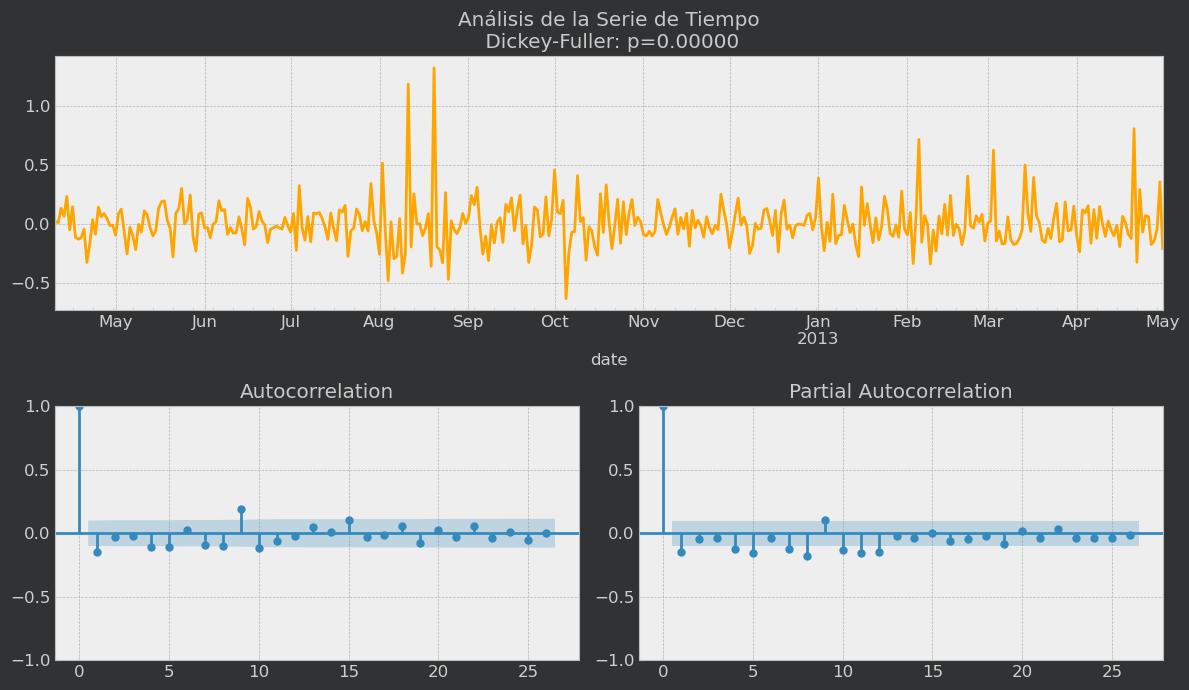

In [9]:
# proceso de diferenciacion 1: residuos entre target real y prediccion modelo reg_log_est
y_test = df_train['log_'+umbral] 
y_real = df_train[umbral]

y_pred = optimized_umbral_model.predict(df_train)

residuo = y_test - y_pred

arima.params_set_plot(residuo)

In [10]:
# from statsmodels.tsa.arima.model import ARIMA# hasta ahora no encontramos contexto para aplicar ARIMA

## VISUALIZACION FORECAST

**MODELO XGBOOST**

In [11]:
error, df_test_xgboost, df_pred_xgboost = xgb.walk_forward_validation(muestra['log_'+umbral].to_frame(), n_test=umbral_2)

df_pred_xgboost.columns = [umbral]
df_test_xgboost.columns = [umbral]

df_pred_xgboost.set_index(df_test.index, inplace=True)
df_test_xgboost.set_index(df_test.index, inplace=True)

y_pred_real = np.exp(df_pred_xgboost)
y_test_real = np.exp(df_test_xgboost)

100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


In [12]:
RMSE = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
line = 'xgboost RMSE prediction = {}'
print (line.format(RMSE))

xgboost RMSE prediction = 26.11936508113341


In [13]:
xgboost_optimize = False
if xgboost_optimize:
    xgboost_scores = {}
    xgboost_predictions = {}
    for i, elemento in enumerate(range(25,76,5)):
        error, df_test_xgboost, df_pred_xgboost = xgb.walk_forward_validation(muestra[umbral].to_frame(), n_test=elemento)
        xgboost_scores['RMSE'] = {f'{elemento}_steps': [np.sqrt(error)]}
        xgboost_predictions
    pd.DataFrame(xgboost_scores)

### PROYECCION

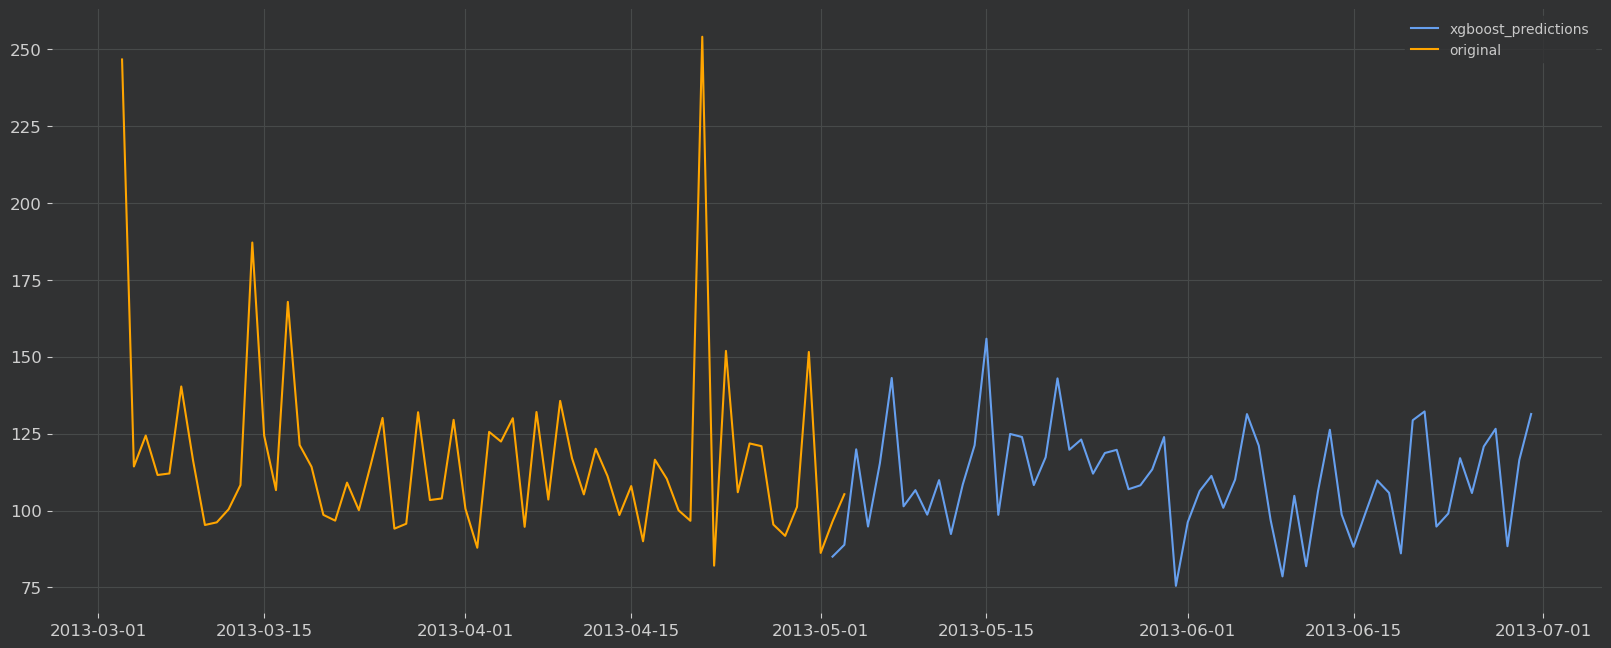

In [14]:
data_view = muestra[[umbral]].iloc[umbral_2*-2:-(umbral_2 + int(-0.0334*umbral_2))]
fig, ax = plt.subplots(figsize=(20,8), dpi=100)
ax.plot(y_pred_real, label='xgboost_predictions')
ax.plot(data_view, label='original', color='orange')
plt.legend(loc='best')#falta graficar la EMA 9 celeste

### DIFERENCIACION SMART SERIES

**PROCESOS DE DIFERENCIACION STANDARD**

Desarrollamos 3 procesos de diferenciacion, primero y para todos, aplicamos transformacion logaritmica sobre la variable target.

El primer proceso es: log - log.SMA(12)

El segundo proceso es: log - log.EMA(12)

el tercer proceso es: log - log.shift()

<br>

Una vez obtenidos los valores del test de Dick-Fuller sobre los 3 procesos seleccionamos el que devuelva un p-value menor.

Así procedemos a optimizar el proceso de diferenciacion resultante (Solo para el primer y segundo proceso).

Se crea una iteración entre distintos valores de medias moviles y se elije la cantidad de pasos backward que devuelven la mejor curva respecto a una respuesta estacionaria.

	DIFFERENTIATION  PROCESS
Selected Method: EMA
Optimized Params: 9



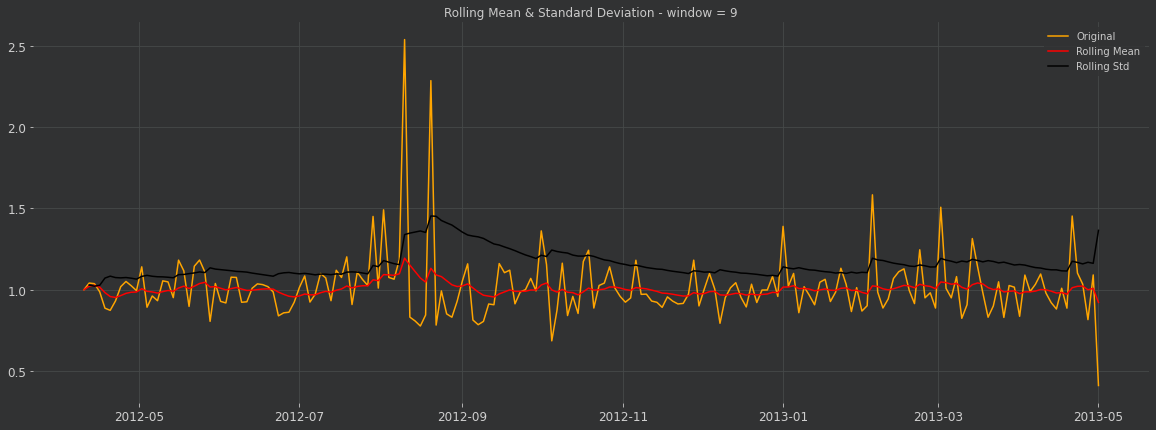

	DICKEY-FULLER TEST
ADF Statistic: -13.20679385069038
p-value: 1.0667953739319704e-24
Critical Values:
	1%: -3.4646940755442612
	5%: -2.8766348847254934
	10%: -2.5748163958763994


In [15]:
diferenciacion = arima.test_stationarity(df_train[umbral].resample('2d').sum())

eval_resid_EMA = False
if eval_resid_EMA:
    arima.params_set_plot(diferenciacion)


In [16]:
EMA_log_test = df_train['log_'+umbral].ewm(9).mean()


error_EMA, df_test_EMA, df_pred_EMA = xgb.walk_forward_validation(EMA_log_test.to_frame(), n_test=60)

df_pred_EMA.columns = [umbral]
df_test_EMA.columns = [umbral]

df_pred_EMA.set_index(df_test.index, inplace=True)
df_test_EMA.set_index(df_test.index, inplace=True)

ema_pred_real = np.exp(df_pred_EMA)
ema_test_real = np.exp(df_test_EMA)

text = 'El RMSE de xgboost_EMA(9) = {}'

print(text.format(np.sqrt(mean_squared_error(ema_pred_real, ema_test_real)))) # real porque predice sobre el logaritmo

100%|██████████| 60/60 [00:11<00:00,  5.25it/s]

El RMSE de xgboost_EMA(9) = 2.9451110661737454


**AÑADIMOS A LA PREDICCION DE LA EMA LA PREDICCION DEL MODELO REG_LOG_EST**

In [17]:
display(check_optimized_model(results_reg_log_est, umbral_3))

reg_test_real = df_test[[umbral]]
reg_pred_real = np.exp(optimized_umbral_model.predict(df_test)).to_frame()

reg_test_real.columns = [umbral]
reg_pred_real.columns = [umbral]

text = 'El RMSE de reg_log_est({}) = {}'
print(text.format(umbral, np.sqrt(mean_squared_error(reg_pred_real, reg_test_real)))) # real porque predice sobre el logaritmo

,Modelo,RMSE
0,log_trend_est,21.1612


El RMSE de reg_log_est(Natural_Products) = 21.161222029231737


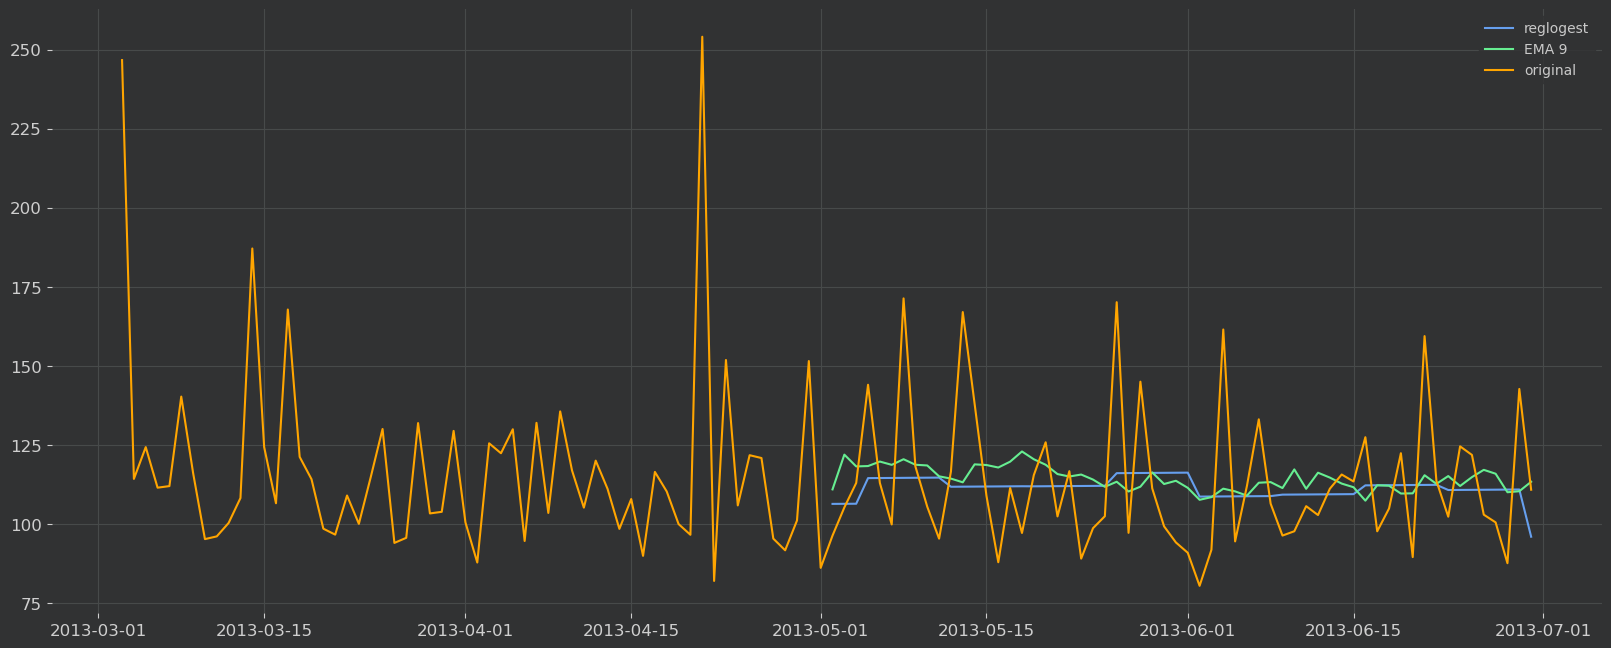

In [18]:
fig, ax = plt.subplots(figsize=(20,8), dpi=100)
ax.plot(reg_pred_real, label='reglogest')#resample('2d').sum()
ax.plot(ema_pred_real, label='EMA 9')
ax.plot(muestra[[umbral]].iloc[-umbral_2*2:], label='original', color='orange')#resample('2d').sum()
plt.legend(loc='best');

El RMSE de reg_log_est(Natural_Products) + EMA(9) = 2.7158962547029866


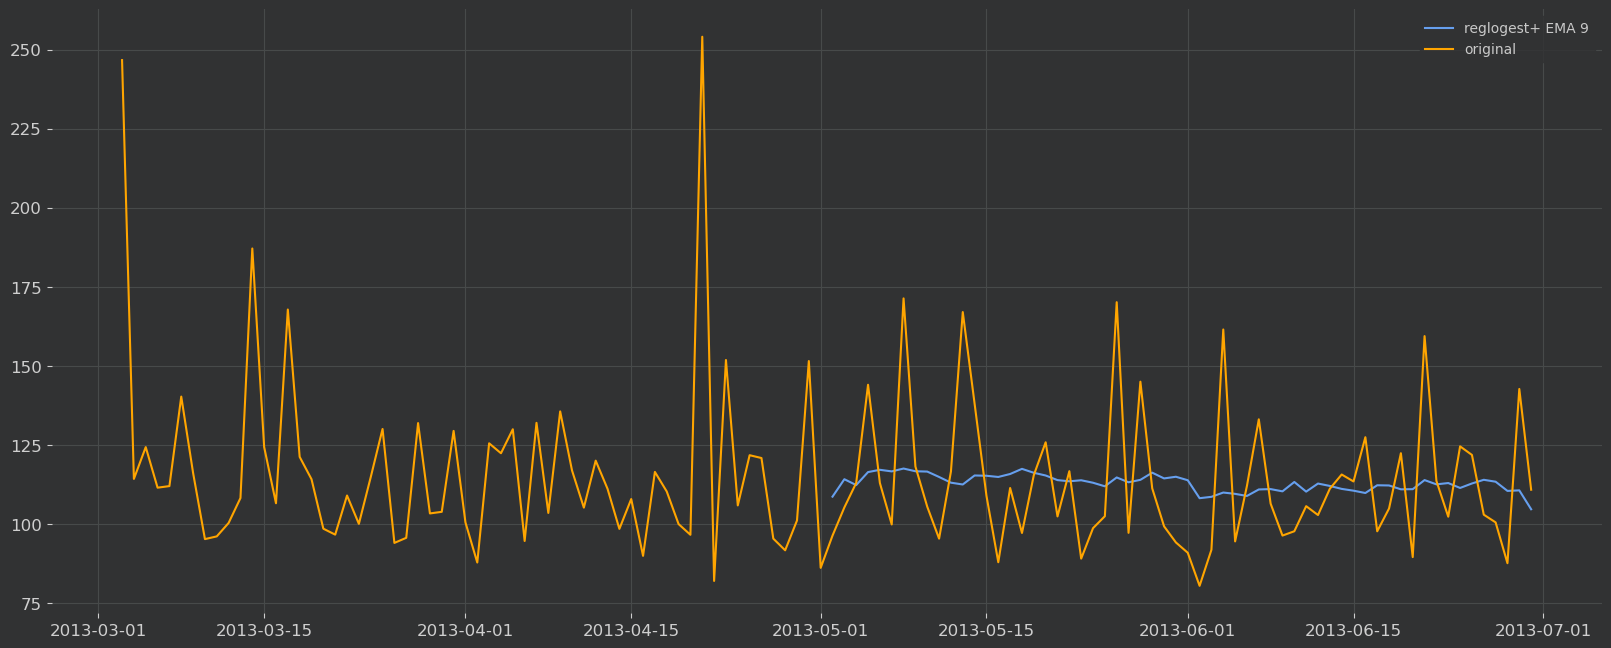

In [19]:
suma_promedio = (reg_pred_real+ema_pred_real)/2
text = 'El RMSE de reg_log_est({}) + EMA(9) = {}'
print(text.format(umbral, np.sqrt(mean_squared_error(reg_pred_real, suma_promedio)))) # real porque predice sobre el logaritmo

fig, ax = plt.subplots(figsize=(20,8), dpi=100)
ax.plot(suma_promedio, label='reglogest+ EMA 9')#resample('2d').sum()
ax.plot(muestra[[umbral]].iloc[-umbral_2*2:], label='original', color='orange')#resample('2d').sum()
plt.legend(loc='best');

## DEPLOY DE MODELOS

**division de los sets**

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

material extra para clasificadores:
https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split
https://scikit-learn.org/stable/modules/grid_search.html#grid-search

In [20]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

spliter = TimeSeriesSplit()
spliter2 = TimeSeriesSplit(n_splits=4, test_size=None, gap=0, max_train_size=None)
spliterv2 = TimeSeriesSplit(n_splits=30, test_size=None)# 

In [21]:
vectores.keys()

dict_keys(['Grocery', 'Pharmaceutical', 'Natural_Products', 'Bakery', 'Meat'])

In [22]:
labels_category = list(vectores.keys())

# visualize data
for i, key in enumerate(labels_category):
    if i == 3: pass#display (vectores[key])#, print (vectores[key].index)

# train test split 
features = {}
targets = {}
for i, key in enumerate(labels_category):

    X, y = train_test_split(vectores[key], test_size=75, shuffle=False)

    #cross validation time serie
    feature = []
    target = []
    for train_index, test_index in spliter2.split(y.index):
        concat_index, predict_index = y.index[train_index], y.index[test_index]
        feature.append(pd.concat([X, y.loc[concat_index]]))
        target.append(y.loc[predict_index])

    features[key] = feature
    targets[key] = target

In [23]:
check = False

if check:
    for i, key in enumerate(labels_category):
        for j in range(len(features[key])):
            display (targets[key][j])

In [24]:
nombre_modelos = reg.def_models()

for ix, key in enumerate(labels_category):
    for j in range(len(features[key])):

        # variable que utilizamos
        frame = features[key][j]
        target = targets[key][j]

        # creamos los vectores
        vector = SmartSeries.VectorBuilder(frame)
        vector.create()
        vector.treatment()
        vector.dummy('W')

        # instanciamos y entrenamos los modelos
        modelos = reg.available_models()
        for i in range(len(modelos)):
            modelos[i] = modelos[i](frame, vector).fit()

        # predecimos con los modelos y evaluamos los scores de los modelos
        scores = []
        for i in range(len(modelos)):
            y_pred = modelos[i].predict(target)
            if i >= 3: y_pred = np.exp(y_pred)
            scores.append(np.sqrt(metrics.mean_squared_error(target[key], y_pred)))

        # evaluamos scores sobre los modelos

        # optmizamos el modelo

        # almacenamos la data

    pass


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date


Serie de tiempo: date



In [25]:
vector.vector

,Meat,log_Meat,timeIndex,timeIndex_sq,sem_00,sem_01,sem_02,sem_03,sem_04,sem_05,...,sem_44,sem_45,sem_46,sem_47,sem_48,sem_49,sem_50,sem_51,sem_52,sem_53
date,,,,,,,,,,,,,,,,,,,,,
2012-04-10,353.698462,5.868445,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-11,222.319762,5.404117,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-12,521.658136,6.257012,2,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-13,521.257895,6.256245,3,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-14,327.602143,5.791800,4,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-11,294.446585,5.685098,427,182329,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-06-12,261.588409,5.566772,428,183184,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-06-13,267.162241,5.587856,429,184041,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# modelos 

muestra = vectores['Meat']
modelos = reg.available_models()
nombre_modelos = reg.def_models()

#train test split: 60 dias = 2 meses
df_train, df_test = train_test_split(muestra, shuffle=False, test_size=60)

# iteracion para instanciar el modelo de statsmodels
for i in range(len(modelos)):
    modelos[i] = modelos[i](muestra, vector)

# iteracion para entrenar los modelos instanciados, y almancenar el score de las predicciones
scores = []
for i in range(len(modelos)):
    modelos[i] = modelos[i].fit()
    y_pred = modelos[i].predict(df_test)
    if i <= 3: y_pred = np.exp(y_pred) # los primeros 4 modelos predicen sobre el logartimo del target
    scores.append(np.sqrt(mean_squared_error(df_test[vector.target], y_pred)))

#resultados = {}
results = pd.DataFrame([nombre_modelos, scores]).T
log_message = '{}) ALTERATION OF VARIABLE TYPE: Cuando creo un dataset a partir de un conjunto de listas, los valores float me los convierte en series tipo "Object"'
logger.warning(log_message.format(x()))
results.columns = ['Modelo', 'RMSE']

log_message = '{}) implementando la funcion "check_optimized_model" tiene hardseteado la label "RMSE", definida previamente en la linea superior a esta'
# aca vamos a usar un dataset aparte, usando "nombre_modelos"
optimized_model = modelos[pd.Series(scores).idxmin()]
optimized_model_v2 = get_optimized_model(modelos, scores)

In [27]:
X

,Meat,log_Meat,timeIndex,timeIndex_sq,sem_00,sem_01,sem_02,sem_03,sem_04,sem_05,...,sem_44,sem_45,sem_46,sem_47,sem_48,sem_49,sem_50,sem_51,sem_52,sem_53
date,,,,,,,,,,,,,,,,,,,,,
2012-04-10,353.698462,5.868445,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-11,222.319762,5.404117,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-12,521.658136,6.257012,2,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-13,521.257895,6.256245,3,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-14,327.602143,5.791800,4,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-04-12,264.025625,5.576046,367,134689,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-04-13,278.716604,5.630196,368,135424,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-04-14,338.700635,5.825117,369,136161,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
check = vectores['Bakery'].index

check

DatetimeIndex(['2012-04-10', '2012-04-11', '2012-04-12', '2012-04-13',
               '2012-04-14', '2012-04-15', '2012-04-16', '2012-04-17',
               '2012-04-18', '2012-04-19',
               ...
               '2013-06-21', '2013-06-22', '2013-06-23', '2013-06-24',
               '2013-06-25', '2013-06-26', '2013-06-27', '2013-06-28',
               '2013-06-29', '2013-06-30'],
              dtype='datetime64[ns]', name='date', length=447, freq=None)

**MODELO DE ENSAMBLE**

In [29]:
#que pasa si entreno un modelo para primera quincena de mayo segunda quincena de mayo, primera quincena de junio, segunda quincena de junio
import statsmodels 

statsmodels.__version__

'0.13.2'

**CONCLUSIONES**